# DC-EGM med Max's Model

## load packages and dependencies

In [61]:
%reload_ext autoreload
%autoreload 2

#Dependencies
import jax.numpy as jnp
import numpy as np
from dcegm.pre_processing.setup_model import setup_model
import jax

from typing import Tuple

import pandas as pd
import matplotlib.pyplot as plt

from dcegm.sim_interface import get_sol_and_sim_func_for_model
from dcegm.simulation.sim_utils import create_simulation_df

from scipy.optimize import minimize

import statsmodels.api as sm

import os
repo_path = os.path.abspath("../")

import sys
sys.path.insert(0,repo_path)

from model_functions_initial.utility import utility_functions
from model_functions_initial.final_period_utility import final_period_utility
from model_functions_initial.budget import budget_dcegm_initial
from model_functions_initial.state_space_functions import create_state_space_function_dict
from model_functions_initial.compute_moments import compute_simulation_moments
from model_functions_initial.compute_moments import compute_simulation_moments_with_ci
from plots.plots import plot_empirical_vs_simulated_with_ci
from model_functions_initial.estimation import estimate_msm
from first_step.load_params import load_params_txt
from model_functions_counter.compute_counterfac import compute_counterfactual_diff
from model_functions_counter.compute_counterfac import plot_counterfactual_diff
from model_functions_counter.compute_counterfac import plot_cf_diff_separate

from model_functions_counter.budget_counter import budget_dcegm_counter_oap

from first_step.mortality import prob_survival

from dcegm.interface import validate_exogenous_processes

# ── Configurating file-location -────────────────────────────────────────────────
DATA_DIR    = repo_path + "/Data"
FILE_UDD1   = os.path.join(DATA_DIR, "momenter/moments_udd1.txt")
FILE_UDD2   = os.path.join(DATA_DIR, "momenter/moments_udd2.txt")
FILE_UDD3   = os.path.join(DATA_DIR, "momenter/moments_udd3.txt")
Mortality   = os.path.join(DATA_DIR, "mortality.xlsx")
# ────────────────────────────────────────────────────────────────────────────────

##### Git Commit Hash 47f27e8 #####
##### Git Branch = origin(aux-budget) #####
# ────────────────────────────────────────────────────────────────────────────────


jax.config.update("jax_enable_x64", True)

## Load Data 

In [62]:
# Read CSV
df_edu = pd.read_csv(FILE_UDD3)
# read mortality and discard seoncd and third column
df_mort = pd.read_excel(Mortality, sheet_name="DOD", usecols=[0, 3])

# 2) standardize colomn name and remove _FREQ_ column
for df in (df_edu, df_edu, df_edu):
    # Rename ALDER → age
    if "ALDER" in df.columns:
        df.rename(columns={"ALDER": "age"}, inplace=True)
    # Remove _FREQ_-column if it exists
    if "_FREQ_" in df.columns:
        df.drop(columns=["_FREQ_"], inplace=True)



# 4) (Valgfrit) Kontrolprint 
df_edu

,age,prob_work,hours_0,hours_1,hours_2,hours_3,hours_4,avg_wealth,work_work,nowork_nowork,avg_experience,avg_labor_income,avg_wage,avg_hours,var_wage,skew_wage,pens
0,30,0.845503,0.154497,0.103766,0.096080,0.102998,0.542659,1.567615,NaN,NaN,NaN,3.321767,0.002144,1493.727273,4.323695e-07,0.810510,NaN
1,31,0.825544,0.174456,0.088235,0.089847,0.101934,0.545528,1.317704,0.773043,0.149653,NaN,3.531975,0.002257,1524.402147,5.666124e-07,0.977457,NaN
2,32,0.811937,0.188063,0.070383,0.083615,0.095158,0.562782,1.428173,0.760302,0.152764,NaN,3.839640,0.002380,1568.221221,7.212581e-07,1.120248,NaN
3,33,0.809074,0.190926,0.067020,0.070935,0.083372,0.587748,1.597427,0.761281,0.162664,NaN,4.021273,0.002450,1600.668944,7.823646e-07,1.151511,NaN
4,34,0.810707,0.189293,0.060202,0.071313,0.080202,0.598990,1.853947,0.761070,0.160773,NaN,4.240941,0.002567,1616.957388,8.994281e-07,1.183978,NaN
5,35,0.809958,0.190042,0.056356,0.074412,0.079336,0.599854,1.984858,0.773077,0.164615,5.878981,4.371871,0.002635,1620.772349,9.691294e-07,1.146467,NaN
6,36,0.858684,0.141316,0.047453,0.054299,0.072862,0.684070,2.631828,0.802997,0.133185,7.809850,5.134637,0.002985,1685.184434,1.424249e-06,1.328096,NaN
7,37,0.882273,0.117727,0.039612,0.049152,0.069597,0.723912,4.686362,0.848833,0.103651,8.692623,5.640217,0.003228,1714.521580,1.752572e-06,1.382758,NaN
8,38,0.897645,0.102355,0.033191,0.041336,0.066110,0.757008,3.415656,0.876109,0.084043,9.496574,6.017228,0.003400,1741.844990,2.129639e-06,1.499691,NaN
9,39,0.905674,0.094326,0.032600,0.039377,0.063239,0.770459,3.731828,0.887830,0.076733,10.287494,6.347196,0.003571,1748.713588,2.436376e-06,1.494523,NaN


## Options for model - Choices and states

In [63]:
n_periods = 55
choices = np.arange(5) # 5 choices

options = {
    "model_params": {
        #"quadrature_points_stochastic": 5, 
        "n_quad_points_stochastic": 5,
        "n_periods": n_periods,
        "choices": choices, # 4 choices
        "hours": jnp.array([0,250,750,1300,1900]), #list 
        "max_hours": 1900,
        "start_age": 30,
        "tax_threshold1": 0.480,
        "tax_threshold2": 5.698,
        "tax_base_rate": 0.38,
        "tax_top_rate": 0.5,
        "retirement_age": 67,
        "oap_base_amount":0.80328,
        "oap_max_supplement": 0.92940,
        "supp_threshold": 0.79300,
        "oap_threshold": 3.3592,
        "supp_reduction_rate": 0.309,
        "oap_reduction_rate": 0.3,
        "alpha1": 0.000417, # independently estimated parameter for survival probability
        "alpha2": 0.1,  # independently estimated parameter for survival probability
        "max_init_experience": 5,
        "max_ret_period": 45, # Age 75
        "min_ret_period": 30, # Age 60
        "counterfac_age": 55,
    },
    "state_space": {
        "n_periods": n_periods,
        "choices": choices, # 4 choices
        "continuous_states": {
            "wealth": np.linspace(0, 50, 20),
            "experience": jnp.linspace(0, 1, 5).astype(float) # 1 experince grid point, if experience can only go up by a year - more points if it is a fraction based on hours worked
        },
        "exogenous_processes": {
            "survival": {
                "transition": prob_survival,
                "states": [0, 1],
            },
        },
    },
}

# ====================================================================================================================

# Structural Estimation

## Initiatal parameters - some are estimated above, the rest to be structuraly estimated

In [64]:
PARAM_FILE = repo_path + "/edu3/optimized_params_udd3.txt"
params = load_params_txt(PARAM_FILE)
params

{'interest_rate': 0.01,
 'sigma': 0.2,
 'taste_shock_scale': 2.4,
 'beta': 0.9862761291459945,
 'rho': 0.4546033105783697,
 'gamma': array([0.6436928 , 1.3013253 , 1.95873805, 1.65679825]),
 'kappa1': 0.009068366633740818,
 'kappa2': 0.001434998756969184,
 'phi': 5.711828977972858,
 'b_scale': 0.5496627563003196,
 'xi': 0.008433463067153925,
 'eta_edu': 1.10158,
 'alpha1': 0.000417,
 'alpha2': 0.099277,
 'beta0': -7.7211014099165185,
 'beta1': 0.07418311839644762,
 'beta2': -0.0005894472446704196}

In [65]:
model_initial = setup_model(
    options=options,
    state_space_functions=create_state_space_function_dict(),
    utility_functions=utility_functions,
    utility_functions_final_period=final_period_utility,
    budget_constraint=budget_dcegm_initial,
)

model_counter = setup_model(
    options=options,
    state_space_functions=create_state_space_function_dict(),
    utility_functions=utility_functions,
    utility_functions_final_period=final_period_utility,
    budget_constraint=budget_dcegm_counter_oap,
)

State specific choice set not provided. Assume all choices are available in every state.
Update function for state space not given. Assume states only change with an increase of the period and lagged choice.
Starting state space creation
State space created.

Starting state-choice space creation and child state mapping.
State, state-choice and child state mapping created.

Start creating batches for the model.
The batch size of the backwards induction is  25
Model setup complete.

State specific choice set not provided. Assume all choices are available in every state.
Update function for state space not given. Assume states only change with an increase of the period and lagged choice.
Starting state space creation
State space created.

Starting state-choice space creation and child state mapping.
State, state-choice and child state mapping created.

Start creating batches for the model.
The batch size of the backwards induction is  25
Model setup complete.



In [66]:
# # validate model
# validate_exogenous_processes(model, params)

# ====================================================================================================================

## Initial values for simulating. 

In [67]:
# Select number of individuals for simulation
n_individuals = 10000

seed = 132
key = jax.random.PRNGKey(0)
n = n_individuals                        



# distribution of initial choices
labels = jnp.array([0, 1, 2, 3, 4], dtype=jnp.int32)
probs  = jnp.array([0.16, 0.15, 0.13, 0.11, 0.43])  # sums to 1.0

lagged_choice = jax.random.choice(
    key,
    a       = labels,
    shape   = (n,),
    p       = probs,
    replace = True
)
# set initial states for each individual
states_initial_init = {
    "period": jnp.zeros(n_individuals),       # Every individual starts at period 0 (age 30)
    "lagged_choice": lagged_choice,  # Every individual starts with choice 3 (work fulltime)
    "experience": jnp.full(n_individuals, 0.8).astype(float),  # Every individual starts with 5 years of experience
    "survival": jnp.ones(n_individuals), # Every individual starts with 1 (alive)
}

# Set wealth at beginning of period, which is the starting wealth for every individual. 
wealth_initial_init = jnp.full(n_individuals, 0.832253)   # Every individual starts with 59k wealth - to be adjusted based on the actual moments

In [68]:
# Select number of individuals for simulation
n_individuals = 10000

seed = 132
key = jax.random.PRNGKey(0)
n = n_individuals                        



# distribution of initial choices
labels = jnp.array([0, 1, 2, 3, 4], dtype=jnp.int32)
probs  = jnp.array([0.259155, 0.118310, 0.108099, 0.108451, 0.405986])  # sums to 1.0

lagged_choice = jax.random.choice(
    key,
    a       = labels,
    shape   = (n,),
    p       = probs,
    replace = True
)
# set initial states for each individual
states_initial_count = {
    "period": jnp.full(n_individuals, 0),       # Every individual starts at period 25 (age 55)
    "lagged_choice": lagged_choice,  # Every individual starts with choice 3 (work fulltime)
    "experience": jnp.full(n_individuals, 0.9).astype(float),  # Every individual starts with 25 ish years of experience
    "survival": jnp.ones(n_individuals), # Every individual starts with 1 (alive)
}

# Set wealth at beginning of period, which is the starting wealth for every individual. 
wealth_initial_count = jnp.full(n_individuals, 2.7)   # Every individual starts with 59k wealth - to be adjusted based on the actual moments

## Simulate model

In [69]:
sim_func_aux_init = get_sol_and_sim_func_for_model(
    model=model_initial,
    states_initial=states_initial_init,
    wealth_initial=wealth_initial_init,
    n_periods=options["state_space"]["n_periods"],
    seed=seed,
)


output_dict_aux_init = sim_func_aux_init(params)

df_sim_init = create_simulation_df(output_dict_aux_init["sim_dict"])

# hours_map = options["model_params"]["hours"]
hours_map = {0: 0, 1: 250, 2: 750, 3: 1300, 4: 1900}
# start_age = options["model_params"]["start_age"]
start_age = 30  # Or start_age = options["model_params"]["start_age"]


moments_sim_init = compute_simulation_moments(df_sim_init, start_age, hours_map)


In [70]:
sim_func_aux_count = get_sol_and_sim_func_for_model(
    model=model_counter,
    states_initial=states_initial_count,
    wealth_initial=wealth_initial_count,
    n_periods=options["state_space"]["n_periods"],
    seed=seed,
)


output_dict_aux_count = sim_func_aux_count(params)

df_sim_count = create_simulation_df(output_dict_aux_count["sim_dict"])

# hours_map = options["model_params"]["hours"]
hours_map = {0: 0, 1: 250, 2: 750, 3: 1300, 4: 1900}
# start_age = options["model_params"]["start_age"]
start_age = 30  # Or start_age = options["model_params"]["start_age"]


moments_sim_count = compute_simulation_moments(df_sim_count, start_age, hours_map)

## Convert simulation results to DataFrame

## Plots

In [71]:
edu = df_edu.copy().loc[df_edu.age <= 75]       # empirical
unexp_moments_sim_count_ci = compute_simulation_moments_with_ci(df_sim_count, start_age, hours_map)  # Call the function
unexp_moments_sim_count_ci = unexp_moments_sim_count_ci.loc[unexp_moments_sim_count_ci.age <= 75]  # Filter simulated + CIs

unexp_moments_sim_init_ci = compute_simulation_moments_with_ci(df_sim_init, start_age, hours_map)  # Call the function
unexp_moments_sim_init_ci = unexp_moments_sim_init_ci.loc[unexp_moments_sim_init_ci.age <= 75]  # Filter simulated + CIs

# location to store plots in
# BASE = "/Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Figurer/Counterfactuals"
# print plots
# plot_empirical_vs_simulated_with_ci(moments_sim_init_ci, moments_sim_count_ci, BASE, out_subfolder="edu1")
# plot_empirical_vs_simulated_with_ci(edu, moments_sim_count_ci, BASE, out_subfolder="edu1")

# edu2.ipynb
# OUT_DIR = repo_path + "/counterfactuals"
# moments_sim_init_ci.to_pickle (os.path.join(OUT_DIR, "moments_init_edu1.pkl"))
# moments_sim_count_ci.to_pickle(os.path.join(OUT_DIR, "moments_cf_edu1.pkl"))
unexp_moments_sim_count_ci


,age,N,prob_work,work_work,nowork_nowork,hours_0,hours_1,hours_2,hours_3,hours_4,...,avg_hours_upper,avg_consumption_se,avg_consumption_lower,avg_consumption_upper,avg_experience_se,avg_experience_lower,avg_experience_upper,avg_labor_income_se,avg_labor_income_lower,avg_labor_income_upper
0,30,10000,0.778300,0.705900,0.182300,0.221700,0.097600,0.100400,0.099400,0.480900,...,1480.056385,0.006402,1.876940,1.902037,NaN,NaN,NaN,NaN,NaN,NaN
1,31,10000,0.809000,0.742700,0.155400,0.191000,0.083900,0.092000,0.093900,0.539200,...,1539.831203,0.007420,1.956226,1.985314,0.000713,5.848833,5.851629,0.022024,2.872655,2.958991
2,32,10000,0.835700,0.775900,0.131200,0.164300,0.079600,0.087200,0.088700,0.580200,...,1570.236803,0.008606,2.053909,2.087644,0.002239,6.639093,6.647871,0.022567,3.243235,3.331698
3,33,9997,0.849155,0.800040,0.115235,0.150845,0.067220,0.085326,0.085726,0.610883,...,1603.825057,0.009157,2.195859,2.231753,0.004118,7.406162,7.422306,0.023004,3.546469,3.636646
4,34,9997,0.862959,0.815845,0.103731,0.137041,0.060118,0.076823,0.082825,0.643193,...,1635.207742,0.009392,2.357100,2.393916,0.006093,8.165845,8.189730,0.023257,3.805587,3.896756
5,35,9993,0.877214,0.831982,0.091764,0.122786,0.060442,0.077154,0.080256,0.659362,...,1640.346805,0.009465,2.500932,2.538033,0.008062,8.928409,8.960013,0.023680,4.084638,4.177465
6,36,9990,0.888488,0.846647,0.080981,0.111512,0.055656,0.072072,0.079780,0.680981,...,1659.235761,0.009488,2.639953,2.677148,0.009970,9.693800,9.732882,0.024004,4.302708,4.396802
7,37,9988,0.899680,0.859531,0.071386,0.100320,0.055767,0.068482,0.076892,0.698538,...,1668.557835,0.009376,2.774268,2.811024,0.011777,10.467745,10.513911,0.024284,4.552804,4.647998
8,38,9982,0.909938,0.872871,0.063214,0.090062,0.050491,0.067121,0.075937,0.716390,...,1682.899071,0.009274,2.898908,2.935264,0.013472,11.249132,11.301942,0.024612,4.775595,4.872076
9,39,9979,0.913418,0.881251,0.057922,0.086582,0.048702,0.063333,0.076761,0.724622,...,1691.058566,0.009122,3.007830,3.043588,0.015036,12.041189,12.100129,0.024716,5.027171,5.124059


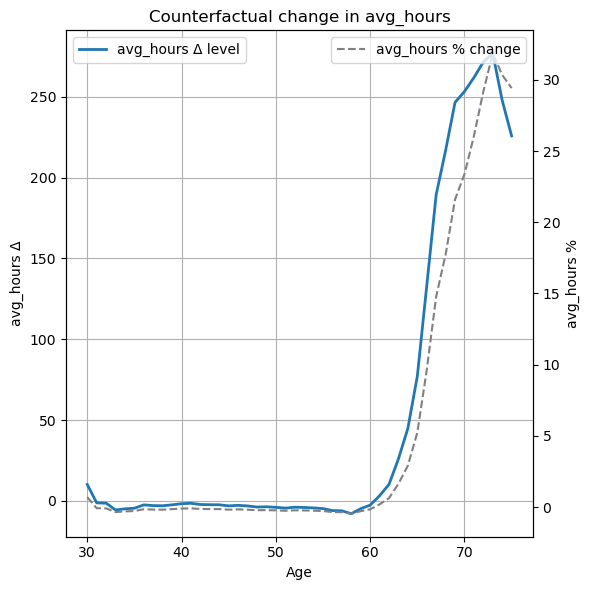

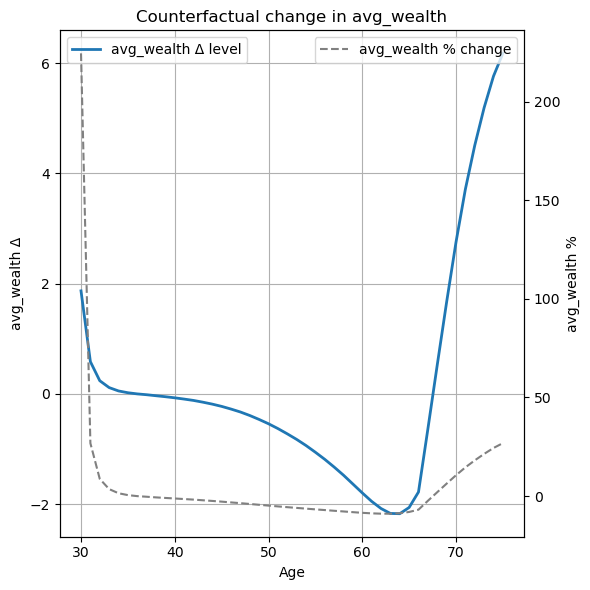

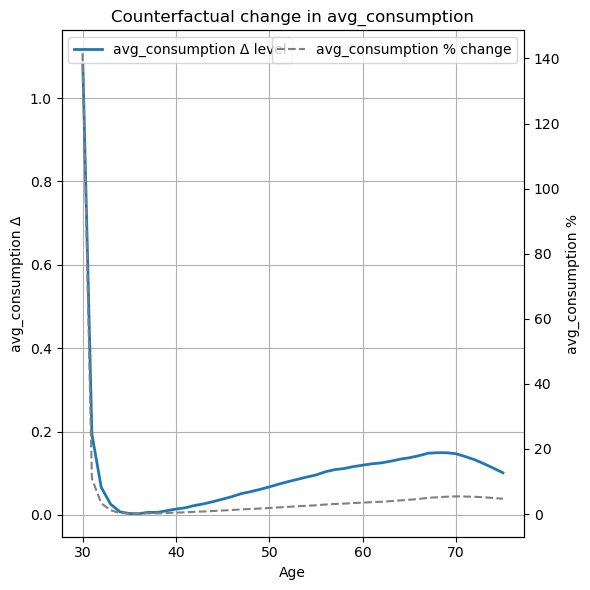

In [72]:
metrics = ['avg_hours', 'avg_wealth', 'avg_consumption']
df_diff = compute_counterfactual_diff(
    df_base = unexp_moments_sim_init_ci,
    df_cf   = unexp_moments_sim_count_ci,
    metrics = metrics
)

df_diff 

plot_cf_diff_separate(df_diff, metrics)

In [73]:
# Select number of individuals for simulation
n_individuals = 10000

seed = 132



key = jax.random.PRNGKey(0)              # whatever seed you like
n = n_individuals                        # how many draws


# define your class‐labels and their probabilities
labels = jnp.array([0, 1, 2, 3, 4], dtype=jnp.int32)
probs  = jnp.array([0.154497, 0.103766, 0.096080, 0.102998, 0.542659])  # sums to 1.0

lagged_choice = jax.random.choice(
    key,
    a       = labels,
    shape   = (n,),
    p       = probs,
    replace = True
)
# set initial states for each individual
states_initial = {
    "period": jnp.zeros(n_individuals),       # Every individual starts at period 0 (age 30)
    "lagged_choice": lagged_choice,  # Every individual starts with choice 3 (work fulltime)
    "experience": jnp.full(n_individuals, 0.3).astype(float),  # Every individual starts with 5 years of experience
    "survival": jnp.ones(n_individuals), # Every individual starts with 1 (alive)
}

# Set wealth at beginning of period, which is the starting wealth for every individual. 
wealth_initial = jnp.full(n_individuals, 1.567615)   # Every individual starts with 59k wealth - to be adjusted based on the actual moments


State specific choice set not provided. Assume all choices are available in every state.
Update function for state space not given. Assume states only change with an increase of the period and lagged choice.
Starting state space creation
State space created.

Starting state-choice space creation and child state mapping.
State, state-choice and child state mapping created.

Start creating batches for the model.
The batch size of the backwards induction is  25
Model setup complete.

State specific choice set not provided. Assume all choices are available in every state.
Update function for state space not given. Assume states only change with an increase of the period and lagged choice.
Starting state space creation
State space created.

Starting state-choice space creation and child state mapping.
State, state-choice and child state mapping created.

Start creating batches for the model.
The batch size of the backwards induction is  25
Model setup complete.

{'period': array([25, 25, 25

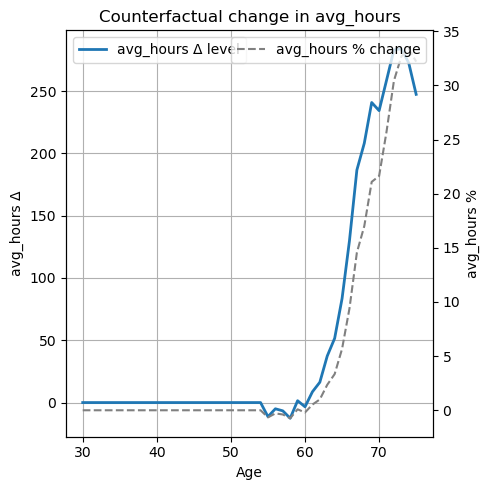

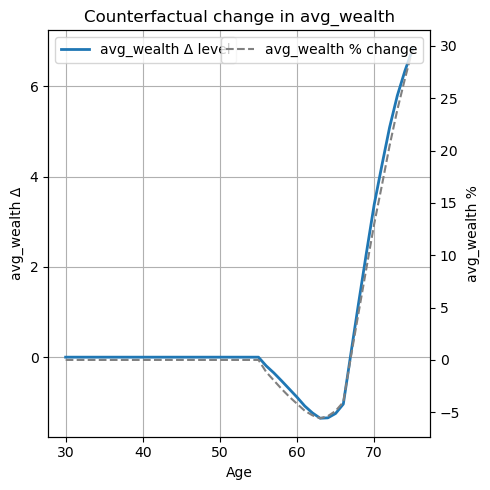

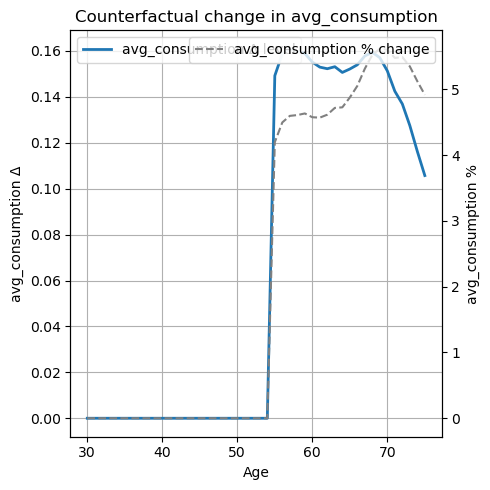

,index,period,agent,acc_exp,choice,consumption,experience,income_shock,labor_income,lagged_choice,...,taste_shocks_0,taste_shocks_1,taste_shocks_2,taste_shocks_3,taste_shocks_4,value_choice_0,value_choice_1,value_choice_2,value_choice_3,value_choice_4
0,0,0,0,NaN,4,1.567615,0.300000,0.010793,NaN,4,...,2.460730,-3.766794,-0.640852,0.350681,1.590148,19.577820,11.980219,15.455858,16.533732,26.547110
1,1,0,1,NaN,4,1.567615,0.300000,0.007171,NaN,4,...,0.364439,6.145293,0.134789,-0.009465,2.801143,17.481529,21.892306,16.231500,16.173586,27.758105
2,2,0,2,NaN,0,0.807631,0.300000,-0.051084,NaN,0,...,-3.470237,2.051695,-1.916921,-2.797782,-3.245780,19.358682,17.798707,14.179790,13.385268,15.999353
3,3,0,3,NaN,4,1.567615,0.300000,-0.018405,NaN,3,...,0.663385,-1.045934,4.064670,1.029717,7.069969,17.780475,14.701078,20.161381,22.924597,26.315102
4,4,0,4,NaN,4,1.567615,0.300000,0.076675,NaN,4,...,2.748594,-0.061857,-2.009744,-3.795353,-0.764299,19.865684,15.685155,14.086967,12.387697,24.192663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,249995,24,9995,24.274047,4,3.736203,0.803085,-0.142580,8.131655,4,...,3.557922,2.063316,-4.958746,-3.558906,0.438288,17.659387,15.814378,8.981741,10.618567,23.848614
249996,249996,24,9996,23.250454,4,3.678254,0.760436,0.005062,9.220877,4,...,6.485141,-2.181400,3.489930,1.974442,3.575588,19.625675,10.625257,16.506245,15.241342,26.101002
249997,249997,24,9997,25.602541,2,3.493396,0.858439,-0.066443,9.045920,4,...,4.115876,0.125773,5.515971,-4.360091,-4.984000,19.886946,15.517335,21.067540,11.406281,19.972301
249998,249998,24,9998,17.914701,1,3.015428,0.538113,0.040062,5.473578,4,...,-1.228106,14.058616,2.565504,1.303224,3.012895,10.878778,25.855636,14.601272,13.606704,24.605177


In [74]:
# ──────────────────────────────────────────────────────────────────────────────
# 0) Unpack & alias your inputs
# ──────────────────────────────────────────────────────────────────────────────
op_m       = options["model_params"]
n_periods  = op_m["n_periods"]
start_age  = op_m["start_age"]
shock_age  = op_m["counterfac_age"]
shock_t    = shock_age - start_age   # the period index when the shock hits
wealth_grid= np.array( options["state_space"]["continuous_states"]["wealth"] )

# ──────────────────────────────────────────────────────────────────────────────
# 1) Solve & simulate under the INITIAL budget
# ──────────────────────────────────────────────────────────────────────────────
model_init = setup_model(
    options                        = options,
    state_space_functions          = create_state_space_function_dict(),
    utility_functions              = utility_functions,
    utility_functions_final_period = final_period_utility,
    budget_constraint              = budget_dcegm_initial,
)
solver_init = get_sol_and_sim_func_for_model(
    model_init,
    states_initial,
    wealth_initial,
    n_periods,
    seed,
)
out_init     = solver_init(params)
sim_dict_init= out_init["sim_dict"]
df_init      = create_simulation_df(sim_dict_init)
df_init = df_init.reset_index()
# df_init has columns "period", "age", "choice", "lagged_choice", "survival",
# "experience", "wealth_beginning_of_period", etc.

# ──────────────────────────────────────────────────────────────────────────────
# 2) Solve under the COUNTERFACTUAL budget (we’ll only need it for continuation)
# ──────────────────────────────────────────────────────────────────────────────
model_cf = setup_model(
    options                        = options,
    state_space_functions          = create_state_space_function_dict(),
    utility_functions              = utility_functions,
    utility_functions_final_period = final_period_utility,
    budget_constraint              = budget_dcegm_counter_oap,
)
# We will call this solver *twice* with different initial states, below.

# ──────────────────────────────────────────────────────────────────────────────
# 3) Slice off the “pre‐shock” history
# ──────────────────────────────────────────────────────────────────────────────
df_pre = df_init.loc[df_init["period"] < shock_t]
df_pre = df_pre.reset_index()
df_pre
# ──────────────────────────────────────────────────────────────────────────────
# 4) Extract the state *at* the shock period
# ──────────────────────────────────────────────────────────────────────────────
df_shock0 = df_init.loc[df_init["period"] == shock_t].reset_index(drop=True)
n_agents  = len(df_shock0)
# Build a new states_initial dict for the continuation
# build the period vector
period_shock = df_shock0["period"].values.astype(int)

states_shock = {
    "period":       period_shock,
    "lagged_choice": df_shock0["choice"].values.astype(int),
    "survival":      df_shock0["survival"].values.astype(float),
    "experience":    df_shock0["experience"].values.astype(float),
}

print(states_shock)
# Map the simulated *wealth* into indices on your 1‐D grid
w_shock = df_shock0["wealth_beginning_of_period"].values.astype(float)
cont_shock = np.searchsorted(wealth_grid, w_shock, side="right") - 1
cont_shock = np.clip(cont_shock, 0, len(wealth_grid)-1)

# ──────────────────────────────────────────────────────────────────────────────
# 5) Solve & simulate *from* the shock onward under CF budget
# ──────────────────────────────────────────────────────────────────────────────
n2 = n_periods - shock_t  # how many periods remain
solver_cf2 = get_sol_and_sim_func_for_model(
    model_cf,
    states_shock,
    w_shock,
    n2,
    seed,
)
out_cf2    = solver_cf2(params)
df_cf2     = create_simulation_df(out_cf2["sim_dict"])
df_cf2 = df_cf2.reset_index()

# shift its “period” & “age” so that period=0→shock_t, etc.
df_cf2["period"] += shock_t
df_cf2["age"]     = start_age + df_cf2["period"]

# ──────────────────────────────────────────────────────────────────────────────
# 6) Stitch together full surprise‐shock path
# ──────────────────────────────────────────────────────────────────────────────
df_full = pd.concat([df_pre, df_cf2], ignore_index=True)

# ──────────────────────────────────────────────────────────────────────────────
# 7) Compute moments & plot the counterfactual difference
# ──────────────────────────────────────────────────────────────────────────────
hours_map = {0: 0, 1: 250, 2: 750, 3: 1300, 4: 1900}
mom_base  = compute_simulation_moments(df_init,   start_age, hours_map)
mom_shock = compute_simulation_moments(df_full,   start_age, hours_map)

#filter age+75 away
mom_base  = mom_base.loc[mom_base.age <= 75]
mom_shock = mom_shock.loc[mom_shock.age <= 75]

df_diff   = compute_counterfactual_diff(
    df_base  = mom_base,
    df_cf    = mom_shock,
    metrics  = ["avg_hours", "avg_wealth", "avg_consumption"],
)

plot_cf_diff_separate(
    df_diff,
    ["avg_hours", "avg_wealth", "avg_consumption"],
    fig_size=5
)

df_pre
#print columnname in df_init
# df_init.columns

In [75]:
OUT_DIR = repo_path + "/oap_counterfactuals/unexpected"
mom_base.to_pickle (os.path.join(OUT_DIR, "moments_init_edu3.pkl"))
mom_shock.to_pickle(os.path.join(OUT_DIR, "moments_cf_edu3.pkl"))